In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector,TimeVisProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]



# VIS_MODEL_NAME = 'dvi_grid'

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)


# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)    

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "imgptDVI")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-02 01:38:46.057429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 01:38:46.713155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-02 01:38:46.713229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...


radius,radius tensor(42.5757)
radius,radius tensor(64.7455)
num_samples_per_radius_l [1780, 1117, 701, 440, 276, 173, 108, 68, 42, 26, 16, 10, 6, 4, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 1/1 [00:00<00:00, 5236.33it/s]

Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100
Computing decision regions ...


Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100
grid_samples (40000, 512)


100%|██████████| 1/1 [00:00<00:00, 5714.31it/s]


Successfully load the DVI visualization model for iteration 100


100%|██████████| 1/1 [00:00<00:00, 2508.56it/s]


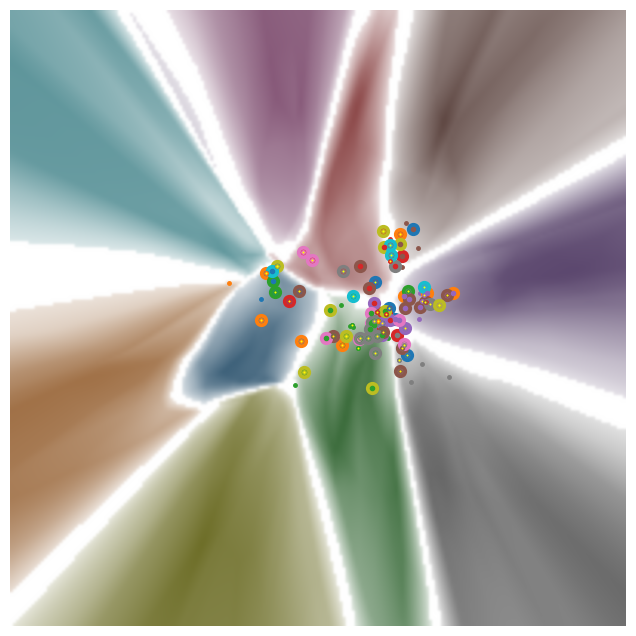

In [34]:
epoch = 100
def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE) 
vis = visualizer(data_provider, projector, 200, "tab10")

train_data = torch.Tensor(data_provider.train_representation(epoch))
train_center = train_data.mean(dim=0)

radius = ((train_data - train_center)**2).sum(dim=1).max().sqrt()

# radius = ((train_data - center)**2).sum(dim=1).max().sqrt()
print("radius,radius",radius)
radii = [radius*1.2 , radius / 2, radius / 100]  # radii at which to sample points

        # 在球体上采样
num_bom_samples = 500  # 设置球面采样数量
high_bom = torch.randn(num_bom_samples, 512)
high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[2]



# X = high_bom.cpu().detach().numpy()
# X = np.concatenate(([train_center.cpu().detach().numpy()], high_bom), axis=0)
 
# X = np.array([train_center.cpu().detach().numpy()])
# high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[2]
from trustVis.skeleton_generator import SkeletonGenerator
skeleton_generator = SkeletonGenerator(data_provider,EPOCH_START)

high_bom = skeleton_generator.skeleton_gen()

X = high_bom[:100]
border = if_border(X)
border_elements_emd = projector.batch_project(epoch, X)
vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 100
Computing decision regions ...
Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100
grid_samples (40000, 512)


100%|██████████| 250/250 [00:00<00:00, 8713.37it/s]


Successfully load the DVI visualization model for iteration 100


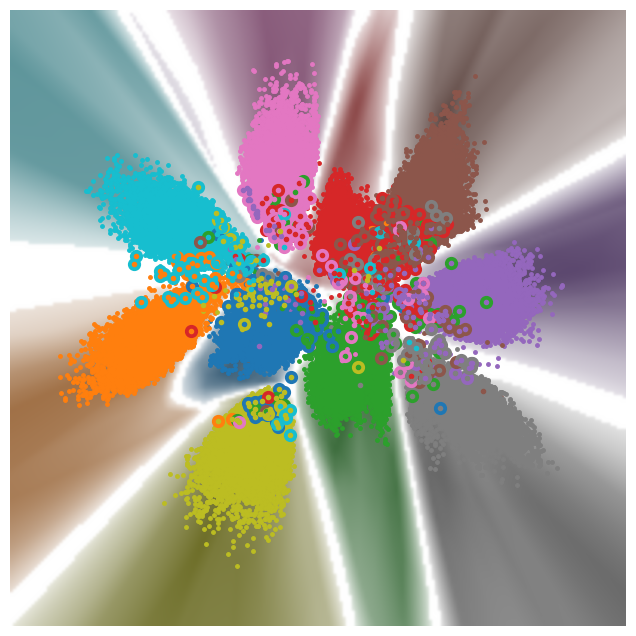

In [35]:
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [3]:
high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[2]

X = high_bom.cpu().detach().numpy()

border = if_border(X)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_ori', device=DEVICE) 
border_elements_emd = projector.batch_project(epoch, X)

vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

100%|██████████| 3/3 [00:00<00:00, 9218.25it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/yifan/0ExpMinist/Default/01/Model/Epoch_1/dvi_ori.pth'

In [36]:
from singleVis.eval.evaluator import Evaluator

projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 100
Wed Aug  2 02:16:13 2023 Building RP forest with 16 trees
Wed Aug  2 02:16:14 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Aug  2 02:16:15 2023 Building RP forest with 16 trees
Wed Aug  2 02:16:15 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.55/15 in epoch 100


1.55064

In [37]:
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 100
Wed Aug  2 02:16:18 2023 Building RP forest with 16 trees
Wed Aug  2 02:16:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Aug  2 02:16:20 2023 Building RP forest with 16 trees
Wed Aug  2 02:16:20 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.59/15 in epoch 100


1.59258

100%|██████████| 3/3 [00:00<00:00, 9039.45it/s]

Computing decision regions ...
grid_samples (40000, 512)


100%|██████████| 3/3 [00:00<00:00, 6820.01it/s]


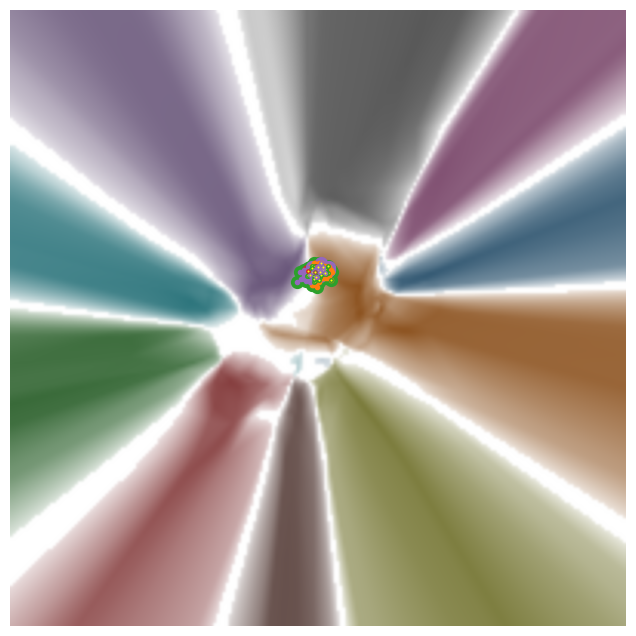

In [71]:
high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[2]

X = high_bom.cpu().detach().numpy()

border = if_border(X)

ENCODER_DIMS = [512,256,256,256,256,2]
      
DECODER_DIMS = [2,256,256,256,256,512]

model = VisModel(ENCODER_DIMS,DECODER_DIMS)
# projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_ori', device=DEVICE) 
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='timevis', device=DEVICE)
border_elements_emd = projector.batch_project(epoch, X)
vis = visualizer(data_provider, projector, 200, "tab10")
# vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))
vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

100%|██████████| 3/3 [00:00<00:00, 6868.40it/s]


Computing decision regions ...
grid_samples (40000, 512)


100%|██████████| 300/300 [00:00<00:00, 7887.64it/s]


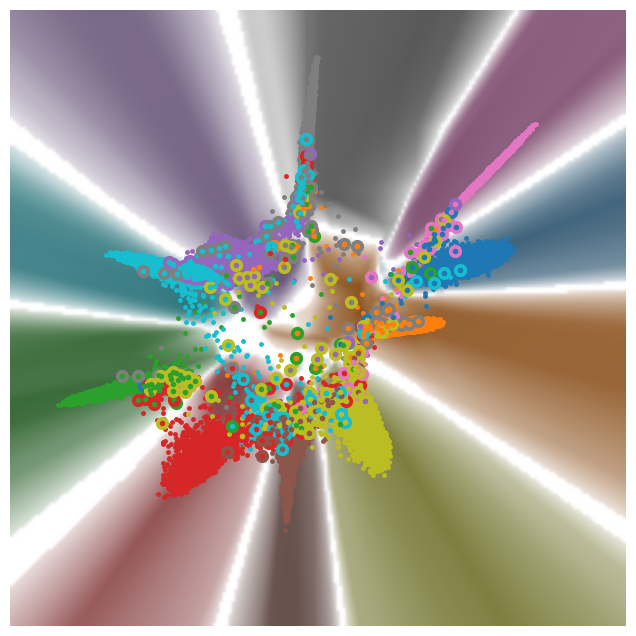

In [72]:
high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[2]

X = high_bom.cpu().detach().numpy()

border = if_border(X)

ENCODER_DIMS = [512,256,256,256,256,2]
      
DECODER_DIMS = [2,256,256,256,256,512]

model = VisModel(ENCODER_DIMS,DECODER_DIMS)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_ori', device=DEVICE) 
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='timevis', device=DEVICE)
border_elements_emd = projector.batch_project(epoch, X)
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))
# vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

100%|██████████| 3/3 [00:00<00:00, 9058.97it/s]


Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5
Computing decision regions ...
Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5
grid_samples (40000, 512)


100%|██████████| 3/3 [00:00<00:00, 8548.17it/s]


Successfully load the DVI visualization model for iteration 5


100%|██████████| 3/3 [00:00<00:00, 7543.71it/s]


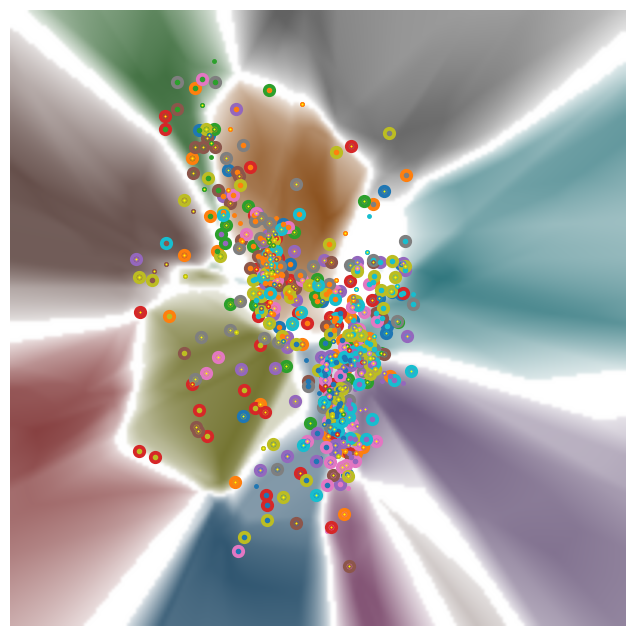

In [61]:
high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[0]

X = high_bom.cpu().detach().numpy()
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
model = VisModel(ENCODER_DIMS,DECODER_DIMS)
border = if_border(X)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE) 
border_elements_emd = projector.batch_project(epoch, X)

vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

100%|██████████| 3/3 [00:00<00:00, 8009.49it/s]

Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8
Computing decision regions ...
Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8
grid_samples (40000, 512)


100%|██████████| 3/3 [00:00<00:00, 6294.60it/s]


Successfully load the DVI visualization model for iteration 8


100%|██████████| 3/3 [00:00<00:00, 5340.79it/s]


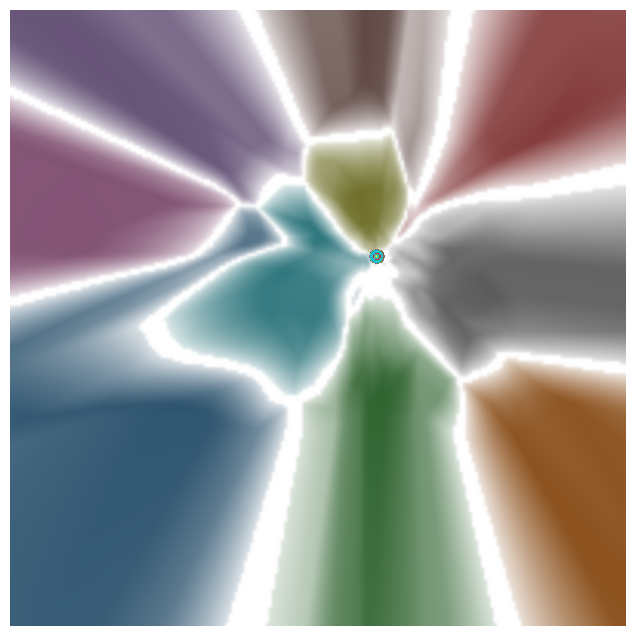

In [17]:
high_bom = high_bom / high_bom.norm(dim=1, keepdim=True) * radii[2]
X = high_bom.cpu().detach().numpy()
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
model = VisModel(ENCODER_DIMS,DECODER_DIMS)
border = if_border(X)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE) 
border_elements_emd = projector.batch_project(epoch, X)
vis = visualizer(data_provider, projector, 200, "tab10")
vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 5
Computing decision regions ...
Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5
grid_samples (40000, 512)


100%|██████████| 300/300 [00:00<00:00, 8184.91it/s]


Successfully load the DVI visualization model for iteration 5


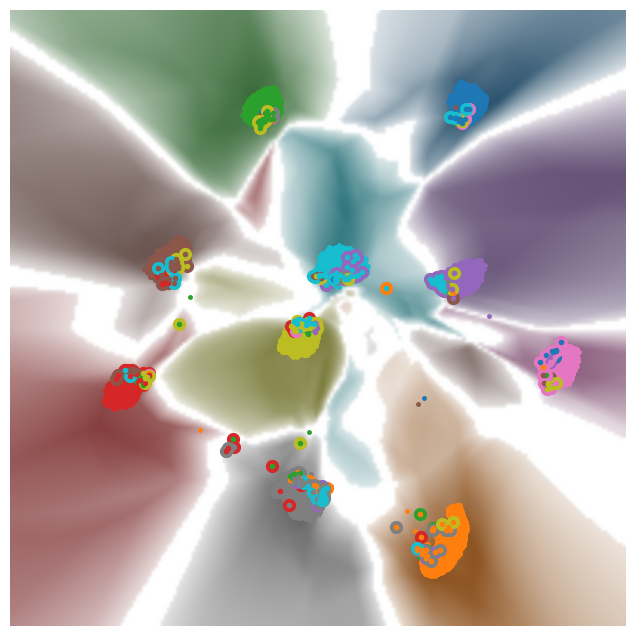

In [35]:
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [6]:
import numpy as np
from scipy.sparse import coo_matrix

def _construct_boundary_wise_complex_center(train_data, border_centers):
    # compute the center of train_data
    center = np.mean(train_data, axis=0)
    fitting_data = np.concatenate((train_data, border_centers), axis=0)

    # compute distances to the center for all points
    distances = np.linalg.norm(fitting_data - center, axis=1)

    # transform distances to weights, smaller distance corresponds to larger weight
    weights = 1.0 / (distances + 1e-8)  # add a small constant to avoid division by zero

    # create a graph where each node is connected to the center
    num_points = fitting_data.shape[0]
    center_index = num_points  # use an additional index to represent the center

    # create rows and cols for COO format sparse matrix
    rows = np.arange(num_points)  # indices for all points
    cols = np.full((num_points,), center_index)  # indices for the center

    # create a sparse adjacency matrix in COO format
    adjacency_matrix = coo_matrix((weights, (rows, cols)), shape=(num_points + 1, num_points + 1))

    bw_head, bw_tail, bw_weight = adjacency_matrix.row, adjacency_matrix.col, adjacency_matrix.data

    return bw_head, bw_tail, bw_weight


In [9]:
train_data

tensor([[0.5203, 1.1733, 0.0000,  ..., 0.7428, 0.0000, 0.0000],
        [0.2645, 0.0000, 0.0000,  ..., 0.0000, 1.8660, 1.1432],
        [1.0350, 0.0000, 2.1085,  ..., 0.0000, 0.0000, 0.3121],
        ...,
        [0.0000, 1.7440, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2601, 0.2208, 0.8322,  ..., 0.0000, 2.7064, 1.8558],
        [1.3106, 0.1836, 0.5334,  ..., 2.9175, 0.0000, 1.0331]])

In [10]:
bw_head, bw_tail, bw_weight = _construct_boundary_wise_complex_center(data_provider.train_representation(epoch), X)

In [16]:
bw_head

array([    0,     1,     2, ..., 64997, 64998, 64999], dtype=int32)

In [17]:
bw_tail

array([65000, 65000, 65000, ..., 65000, 65000, 65000], dtype=int32)

In [14]:
bw_weight[:100]

array([0.05815158, 0.05075733, 0.06001547, 0.05749525, 0.05372053,
       0.0474598 , 0.05069556, 0.05141095, 0.05297805, 0.04638589,
       0.05278536, 0.04791267, 0.04221045, 0.04953925, 0.05264167,
       0.04895431, 0.0571011 , 0.05758579, 0.05531636, 0.05658653,
       0.04714873, 0.05044521, 0.05481624, 0.05577889, 0.05717774,
       0.0517469 , 0.04710513, 0.04488309, 0.0561362 , 0.07030788,
       0.04490791, 0.05713075, 0.0563271 , 0.05218559, 0.05168999,
       0.06201578, 0.05437108, 0.04987923, 0.04851503, 0.05855941,
       0.05035832, 0.04991852, 0.05674845, 0.05075448, 0.04404112,
       0.04955417, 0.05091814, 0.04940876, 0.06491349, 0.05265297,
       0.04701947, 0.05849263, 0.05223786, 0.04665209, 0.06216676,
       0.06255487, 0.04765532, 0.04515781, 0.04711024, 0.05696263,
       0.06318133, 0.0448419 , 0.05316279, 0.06276903, 0.05552131,
       0.0467979 , 0.04769228, 0.06878991, 0.04692173, 0.05675115,
       0.06174817, 0.04872493, 0.05349392, 0.04930945, 0.04574

In [15]:
print(bw_weight[-100:])

[0.03221654 0.0317851  0.03177091 0.03278468 0.03203519 0.03151123
 0.031909   0.03135762 0.03297133 0.03247403 0.03166787 0.03204457
 0.03275231 0.03248433 0.03209278 0.03197386 0.03269419 0.03214119
 0.03170093 0.03117    0.03176066 0.0315655  0.03269228 0.03241392
 0.03141582 0.03279753 0.03184214 0.03093634 0.03143738 0.03205987
 0.03109365 0.03218609 0.03146724 0.03274698 0.03135838 0.03216304
 0.0322708  0.03309273 0.03094058 0.03204449 0.0314476  0.03244754
 0.03271624 0.03154279 0.03338752 0.0324185  0.031525   0.03191512
 0.03291854 0.03071982 0.03169203 0.03218612 0.0323986  0.03177556
 0.03269235 0.03232161 0.03306624 0.03216451 0.03213118 0.03144922
 0.03168701 0.03157939 0.03114528 0.03255966 0.0323916  0.03115222
 0.03227827 0.03208003 0.03250081 0.03171969 0.03146604 0.03151942
 0.03150151 0.0308926  0.03214545 0.03100076 0.03150911 0.03202022
 0.03254658 0.03142441 0.0327478  0.03260614 0.03230157 0.03127873
 0.0320017  0.03190205 0.03231853 0.03117319 0.03175741 0.0329

In [20]:
epoch = 60

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.train_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.train_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 60
Successfully load the DVI visualization model for iteration 60


100%|██████████| 250/250 [00:00<00:00, 8858.46it/s]


vis error num: 2118 vis error on boundary:  1875 boundary flip: 5696
